In [ ]:
!apt-get -y install fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [ ]:
!pip install shap scikit-learn joblib

In [ ]:
# 데이터 로드
!gdown 1G7K6jL3MiZl9-Bnz9ux-20CQ2DjZ0y_L

## shap 분석  

### 변수 설명 (상위 10)  
- 역세권점포비율: 지하철 반경 500m 이내 점포 비율  
- 대분류명 인코딩: 종 대분류 라벨 인코딩  
- 건당 평균 결제금액: 업종별 지역화폐 거래 데이터를 활용해 계산한 지표, 특정 업종 내에서 소비자가 한 번에 지불한 금액의 평균을 나타냄  
- 월별 총거래금액: 업종별 지역화폐 거래 데이터를 활용해 월 단위 전체 거래 규모를 측정한 값  
- 지역화폐가맹률: 해당 행정동의 전체 점포 중 동백전 가맹점 비율  
- 총이용금액: 행정동 단위 소비 매출 데이터에서 계산된 카드사 기준 총 사용금액  
- 가맹률 추세: 지역화폐 가맹률의 변화 방향성
- 총주거인구수: 해당 행정동의 전체 거주 인구 수   


In [4]:
# 데이터 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/final_analysis_v3_cleaned_full.csv")

# 라벨 인코딩
for col in ["대분류명", "행정동", "시군구"]:
    df[col + "_인코딩"] = LabelEncoder().fit_transform(df[col])

# 수치형 변환
for col in ['지역화폐가맹률', '폐업률', '총방문인구수', '건당_평균_결제금액', '역세권점포비율', '총이용금액']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ""), errors="coerce")

# 로그 변환
for col in ['총방문인구수', '총주거인구수', '총이용금액']:
    df[col] = np.log1p(df[col])

# 파생 변수 생성
df['가맹률_이동평균'] = df.groupby(['시군구', '행정동'])['지역화폐가맹률'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df['가맹률_추세'] = df['지역화폐가맹률'] - df['가맹률_이동평균']
df['월'] = pd.to_datetime(df['기준연월']).dt.month

# y값 정의 (폐업률이 0보다 크면 페업(1), 아니면 영업중(0))
df["폐업여부"] = (df["폐업률"] > 0).astype(int)
y = df["폐업여부"]

# 피처 정의 (모델링 코드에서 상관관계 및 vif 계산하여 선정한 피처)
features = ['여성비율_방문', '저녁_소비비율', '30대_비율', '월별_총거래금액',
            '지역화폐가맹률', '총방문인구수', '총이용금액', '건당_평균_결제금액',
            '대분류명_인코딩', '시군구_인코딩', '행정동_인코딩', '가맹률_추세', '총주거인구수', '역세권점포비율']
X = df[features].fillna(0).astype("float32")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
import joblib, shap

# 모델 로드
model = joblib.load("xgb_final_model.pkl")

# 샘플링
X_sample = X_train.sample(n=5000, random_state=42)

# TreeExplainer로 SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

### SHAP Bar Plot  

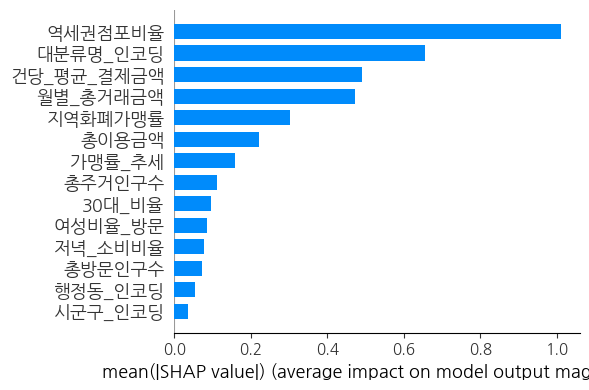

In [6]:
# shap summary_plot (Bar)
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)

plt.gcf().set_size_inches(6, 4)
plt.tight_layout()
plt.show()

#### 해석    
- 역세권 여부(입지 조건)와 업종 특성이 폐업 예측에 매우 큰 영향을 미침
- 업종별 지역화폐 데이터로 부터 계산된 건당 평균 결제 금액, 총 거래 금액이 세번째, 네번쨰로 예측에 중요하게 작용함. 이는 고단가 업종이거나 소비활동이 활발한 업종일수록 폐업 가능성이 낮을 수 있음을 보여줌
- 지역화폐 가맹률과 가맹률 추세도 주목할만한 변수로 가맹률이 높거나 상승 추세인 행정동의 경우 상대적으로 폐업 위험이 낮게 예측되는 경향이 있음  

### Dot Plot  
- 구조: x축 shap value: 모델 예측값에 대한 영향력의 방향과 크기 (양수=폐업가능성 높음/음수=폐업가능성 낮음)
- 점의 색깔: 해당 변수의 실제 값 크가(빨강=high/파랑=Low)  




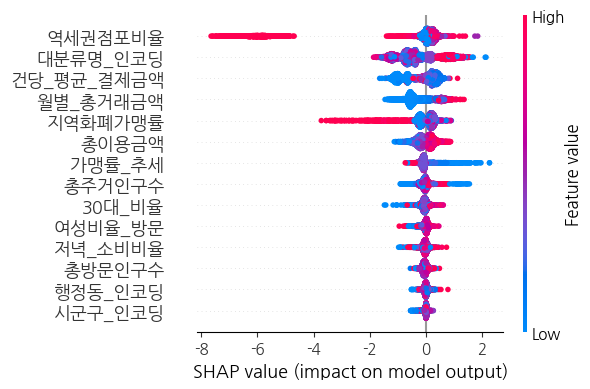

In [7]:
# SHAP summary plot (Dot)
shap.summary_plot(shap_values, X_sample, show=False)
plt.gcf().set_size_inches(6, 4)
plt.tight_layout()
plt.show()

#### 해석
- **역세권점포비율**
  - 빨간색 점들이 오른쪽에 몰려 있음 -> 역세권 비율이 높을수록 폐업 가능성 낮음  
  - 음수쪽으로 강하게 작용 -> 생존 가능성 증가 요인  
  - 입지 조건이 좋은 점포는 폐업 위험이 낮음  
- **대분류명 인코딩(업종변수 라벨 인코딩)**  
  - 폐업 예측에 강력하게 작용하지만 shap 값 분포가 넓음 -> 업종별로 폐업 가능성이 미치는 영향이 다름
- **건당 평균 결제금액**
    - 음수 방향에 파란 점들이 더 많음  
    - 건당 평균 결제금액이 낮은 경우 모델은 폐업 확률을 낮게 예측한 경향이 있음  
    - 빨간점은 가운데 ~ 오른쪽까지 퍼져 있음  
    - 건당 결제 금액이 높을수록 폐업 확률을 높게 본 경우도 있고 낮게 본 경우도 있음  
- **월별 총거래금액**
  - 거래금액이 높을수록 shap값이 음수 -> 폐업 가능성이 낮음  
  - 소비 활동이 활발한 업종은 생존 가능성이 큼  
- **지역화폐가맹률**
  - 높은 가맹률일수록 shap 값이 음수
  - 지역화폐 가맹점이 많은 행정동일수록 폐업 가능성이 낮음  
- **총이용금액**
  - 빨간점이 왼쪽에 몰려 있으므로 소비활동이 많은 지역은 폐업 위험이 낮음  

### Dependence Plot  

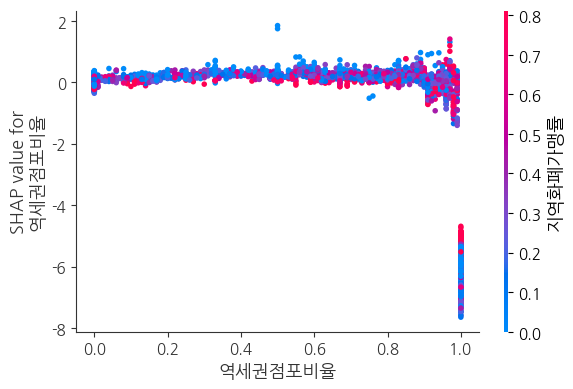

In [8]:
# SHAP 의존도 플롯 (summary_plot과 동일한 스타일)
shap.dependence_plot(ind='역세권점포비율', shap_values=shap_values, features=X_sample, show=False)

plt.gcf().set_size_inches(6, 4)
plt.tight_layout()
plt.show()

#### 해석
- 역세권점포비율이 1에 가까울수록 shap값이 -4이하로 떨어지며, 해당 변수가 폐업 위험을 낮추는 요인으로 작용함을 알 수 있음  
- 데이터 자체가 역세권점포비율 = 1.0인 경우 폐업이 아닌 경우가 많아서 모델이 해당 조건을 학습했을 가능이 높음
- 역세권점포비율과 상호작용이 많은 변수로 지역화폐가맹률이 자동 선택되었지만 그래프에서의 색상 분포가 shap 값에 뚜렷한 영향을 주지 않는 것으로 보임 -> 두 변수간 상호작용이 크지 않음  

### Force Plot  

In [11]:
# 중요도 기준 상위 8개 feature
shap_vals_array = shap_values
expected_value = explainer.expected_value

top_6_idx = np.argsort(np.abs(shap_vals_array[0]))[::-1][:6]

shap.initjs()
force_plot = shap.force_plot(
    base_value=expected_value,
    shap_values=shap_vals_array[0][top_6_idx],
    features=X_sample.iloc[0][top_6_idx],
    feature_names=X_sample.columns[top_6_idx]
)
force_plot

/tmp/ipython-input-11-3704776383.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features=X_sample.iloc[0][top_6_idx],


#### 해석
-  해당 샘플은 비폐업(생존)으로 예측되었으며, 모델의 기준값인 0.0214보다 낮은 -1.27로 예측됨
- 대분류 업종, 가맹률 추세, 건당 평균 결제금액은 폐업 위험을 낮추는 주요 요인으로 작용  
- 반면, 역세권 점포 비율과 지역화폐 가맹률은 해당 샘플에서 폐업 위험을 높이는 방향으로 작용함

# 모델 예측값 기반 위험 지수 계산
모델 예측 확률과 정책 취약 지표를 합산한 후 0~1 범위로 표준화하여 폐업 위험도 지수를 산출

In [12]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
import textwrap

# 모델 예측 확률 추가
pred_probs = model.predict_proba(df[features].fillna(0).astype(np.float32))[:, 1]

# 위험 점수 계산 (모델 예측결과 비중: 0.8)
df = df.reset_index(drop=True)
df["pred_prob"] = pred_probs
df["위험점수_raw"] = (
    pred_probs * 0.8 +                 # 모델 예측 확률 80% 반영
    (1 - df["지역화폐가맹률"]) * 0.1 +
    (1 - df["총방문인구수"]) * 0.05 +
    (1 - df["역세권점포비율"]) * 0.05
)

# 정규화
scaler = MinMaxScaler()
df["위험점수"] = scaler.fit_transform(df[["위험점수_raw"]])

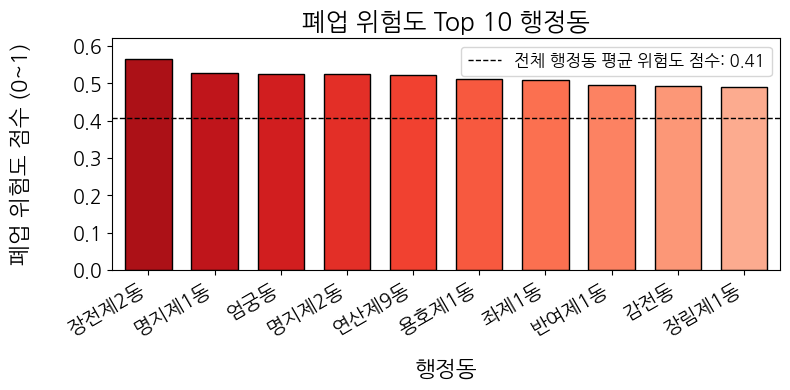

In [13]:
# 행정동별 평균 위험 점수 계산
top10_dong_norm = (
    df.groupby("행정동")["위험점수"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# 전체 평균 위험도 계산
avg_risk_score = df["위험점수"].mean()

# 색상 설정
colors = cm.Reds(np.linspace(0.3, 0.85, len(top10_dong_norm)))

# 시각화
plt.figure(figsize=(8, 4))
bars = plt.bar(
    top10_dong_norm["행정동"],
    top10_dong_norm["위험점수"],
    color=colors[::-1],  # 색상 반전
    edgecolor="black",
    width=0.7
)

# 전체 평균 점선 및 범례
plt.axhline(
    avg_risk_score,
    color="black",
    linestyle="--",
    linewidth=1.,
    label=f"전체 행정동 평균 위험도 점수: {avg_risk_score:.2f}"
)
plt.legend(fontsize=12, loc="upper right")

plt.xlabel("행정동", fontsize=16, labelpad=15)
plt.ylabel("폐업 위험도 점수 (0~1)", fontsize=16, labelpad=30)
plt.title("폐업 위험도 Top 10 행정동", fontsize=18)
plt.xticks(rotation=30, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, top10_dong_norm["위험점수"].max() * 1.1)
plt.margins(x=0.02)

plt.tight_layout()
plt.show()

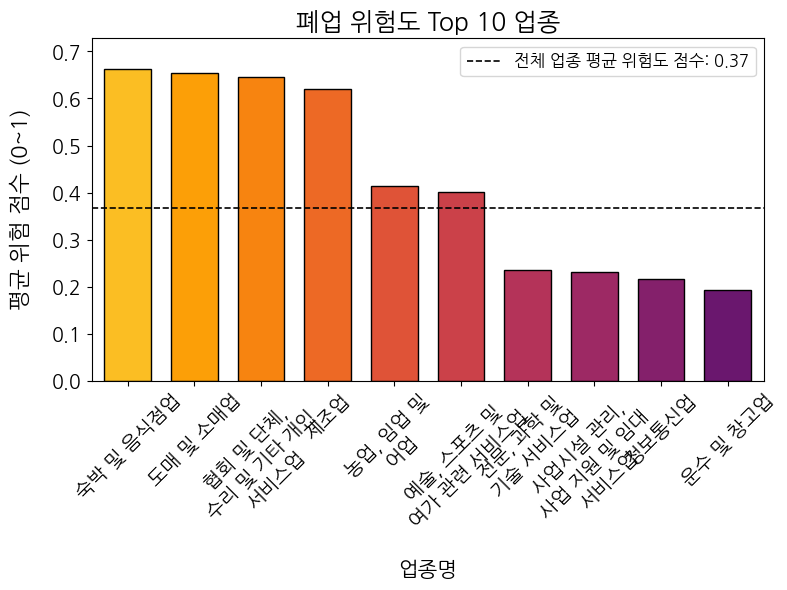

In [15]:
# 업종명 복원
encoder = LabelEncoder()
encoder.fit(df["대분류명"])
df["대분류명_복원"] = encoder.inverse_transform(df["대분류명_인코딩"])

# 업종별 평균 위험도 계산
industry_risk = (
    df.groupby("대분류명_복원")["위험점수"]
    .mean()
    .sort_values(ascending=False)
    .head(10)  # 위험도 Top 10 업종
)

# 전체 업종 위험도 평균치 계산
avg_industry_risk = df.groupby("대분류명_복원")["위험점수"].mean().mean()

# 업종명 자동 줄바꿈
industry_risk.index = [
    "\n".join(textwrap.wrap(label, 10)) for label in industry_risk.index
]

# 색상 설정
colors = cm.inferno(np.linspace(0.3, 0.85, len(industry_risk)))[::-1]

# 시각화
plt.figure(figsize=(8, 6))
plt.bar(
    industry_risk.index,
    industry_risk.values,
    color=colors,
    edgecolor="black",
    width=0.7
)

# 평균선
plt.axhline(
    avg_industry_risk,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label=f"전체 업종 평균 위험도 점수: {avg_industry_risk:.2f}"
)
plt.legend(fontsize=12, loc="upper right")

plt.ylabel("평균 위험 점수 (0~1)", fontsize=16, labelpad=15)
plt.xlabel("업종명", fontsize=15, labelpad=16)
plt.title("폐업 위험도 Top 10 업종", fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, industry_risk.values.max() * 1.1)
plt.subplots_adjust(bottom=0.3)
plt.margins(x=0.02)

plt.tight_layout()
plt.show()


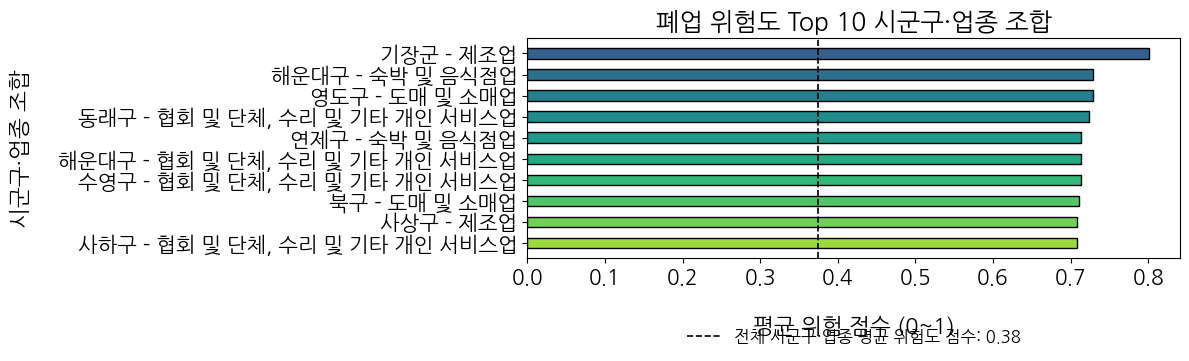

In [18]:
# 시군구 라벨인코딩 복원
gu_encoder = LabelEncoder()
gu_encoder.fit(df["시군구"])
df["시군구_복원"] = gu_encoder.inverse_transform(df["시군구_인코딩"])

# 업종 라벨인코딩 복원
ind_encoder = LabelEncoder()
ind_encoder.fit(df["대분류명"])
df["대분류명_복원"] = ind_encoder.inverse_transform(df["대분류명_인코딩"])

# 구+업종 조합별 평균 위험 점수 계산
top10_gu_ind = (
    df.groupby(["시군구_복원", "대분류명_복원"])["위험점수"]
    .mean()
    .sort_values(ascending=False)  # 위험도 높은 순서
    .head(10)
    .reset_index()
)

top10_gu_ind["조합"] = top10_gu_ind["시군구_복원"] + " - " + top10_gu_ind["대분류명_복원"]
avg_gu_ind_risk = df.groupby(["시군구_복원", "대분류명_복원"])["위험점수"].mean().mean()

colors = cm.viridis(np.linspace(0.3, 0.85, len(top10_gu_ind)))

plt.figure(figsize=(12, 4))
plt.barh(
    top10_gu_ind["조합"][::-1],  # 위험 점수 높은 조합이 위로 오도록
    top10_gu_ind["위험점수"][::-1],
    color=colors[::-1],
    edgecolor="black",
    height=0.5
)
plt.tight_layout(pad=1.5)

# 평균선
plt.axvline(
    avg_gu_ind_risk,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label=f"전체 시군구·업종 평균 위험도 점수: {avg_gu_ind_risk:.2f}"
)
plt.legend(
    fontsize=12,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.25),
    frameon=False
)

# 스타일 업그레이드
plt.xlabel("평균 위험 점수 (0~1)", fontsize=16, labelpad=20)
plt.ylabel("시군구·업종 조합", fontsize=16, labelpad=20)
plt.title("폐업 위험도 Top 10 시군구·업종 조합", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()


# 성과 지표 계산  

In [ ]:
!gdown 12ctuq9pdlZ2GWRj7EuK-BQ-XoEZviCim

In [53]:
# 위험지역 제외한 평균 폐업률
cluster_df = pd.read_csv("/content/gold.busan.cluster_k4 (1).csv", encoding="utf-8-sig")

non_danger_df = cluster_df[cluster_df["cluster"] != 3]
avg_closure_rate_non_danger = round(non_danger_df["폐업률"].mean() * 100, 2)
print(f"위험지역 제외 전체 상권 평균 폐업률: {avg_closure_rate_non_danger:.2f}%")

위험지역 제외 전체 상권 평균 폐업률: 0.62%


In [54]:
# 위험지역 제외한 평균 지역화폐 가맹률
avg_card_rate_non_danger = round(non_danger_df["지역화폐가맹률"].mean() * 100, 2)
print(f"위험지역 제외 전체 상권 평균 지역화폐 가맹률: {avg_card_rate_non_danger:.2f}%")

위험지역 제외 전체 상권 평균 지역화폐 가맹률: 25.83%


In [55]:
# 위험지역의 평균 폐업률, 가맹률
danger_df = cluster_df[cluster_df["cluster"] == 3]

avg_closure_rate_danger = round(danger_df["폐업률"].mean() * 100, 2)
avg_card_rate_danger = round(danger_df["지역화폐가맹률"].mean() * 100, 2)

print(f"위험지역 평균 폐업률: {avg_closure_rate_danger:.2f}%")
print(f"위험지역 평균 지역화폐 가맹률: {avg_card_rate_danger:.2f}%")

위험지역 평균 폐업률: 87.27%
위험지역 평균 지역화폐 가맹률: 1.38%


In [56]:
# 기회지역의 평균 폐업률, 가맹률
danger_df = cluster_df[cluster_df["cluster"] == 2]

avg_closure_rate_danger = round(danger_df["폐업률"].mean() * 100, 2)
avg_card_rate_danger = round(danger_df["지역화폐가맹률"].mean() * 100, 2)

print(f"기회지역 평균 폐업률: {avg_closure_rate_danger:.2f}%")
print(f"기회지역 평균 지역화폐 가맹률: {avg_card_rate_danger:.2f}%")

기회지역 평균 폐업률: 0.30%
기회지역 평균 지역화폐 가맹률: 0.01%
